## Corridors Crash Data (CCD)

### 1. Needs number of crashes, fatalities, injuries, severity categorization, Mode for each corridor in study area
### 2. Database: DOTDEVRHPGSQL01
### 3. Tables: study_area, nysdot_all, fatality_nycdot_current, lion

In [1]:
from ris import db2  #library designed for SQL database connection and querying
from IPython.display import clear_output
import datetime 
from datetime import date
import pandas as pd
import os


clear_output()
timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
print 'Notebook run: {}'.format(timestamp)
print os.getcwd()
# %load_ext sql 

Notebook run: 2019-08-09 10:10
E:\RIS\Staff Folders\Samuel\Requests\SH\Crash_Data


In [2]:
#Database connections
#gdb = db2.PostgresDb('dotdevpgsql02', 'GISGRID', quiet = True)
cdb = db2.PostgresDb('DOTDEVRHPGSQL01', 'CRASHDATA', quiet = True)

User name (CRASHDATA):soge
Password (CRASHDATA)········


### CCD Query

#### This table contains all of the corridor crash statistics inculding segments and intersections for the selected study area 

In [3]:
ccd = (db2.query_to_table(cdb, """

        select id_b, 
        sum(tot_crashes) tot_crashes,
        sum(tot_fat) tot_fat, 
        sum(tot_inj) tot_inj, 
        sum(a) a,
        sum(b) b,
        sum(c) c,
        sum(ksi) ksi,
        sum(unk) unk,
        sum(ped) ped,
        sum(bike) bike 


        from (
        
        --All Crash Details for Segments
        select * from (
        
        --All Block from Segemnts Within Studay Area
        with data as(
        select id_b, segmentid 
        from(select mft,segmentid, geom from lion 
             where mft in (select l.mft from lion l join working.study_area sa on l.segmentid = sa.segmentid)) ll

        join(select sa.id_b, l.mft 
             from lion l join working.study_area sa
             on l.segmentid = sa.segmentid 
             group by id_b, l.mft) id
             on ll.mft = id.mft)

        --Sum of all segment injuries joined with fatalies within study area grouped by id_b
        select x.id_b, 
        count(case_num) tot_crashes, 
        coalesce(id_,0) tot_fat,
        sum(num_of_inj) tot_inj ,
        sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'A'::text, ''::text))) AS A,
        sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'B'::text, ''::text))) AS B,
        sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'C'::text, ''::text))) AS C,
        ABS(sum((num_of_fat + num_of_inj)-length(TRIM(ext_of_inj::text)))) UNK,
        coalesce(id_,0) + sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'A'::text, ''::text))) AS KSI,
        sum(case when accd_type_int= 1 then num_of_inj else 0 end) as Ped,
        sum(case when accd_type_int= 2 then num_of_inj else 0 end) as Bike

        from(

        select distinct id_b, case_num, ext_of_inj, crashid, num_of_fat, num_of_inj, accd_type_int, nys.loc 
        from (select * from nysdot_all where case_yr between 2005 and 2014 and exclude = 0) nys
              join data on nys.segmentid = data.segmentid)x

        left join(select id_b,count(id_) id_ from (select * from fatality_nycdot_current where yr between 2005 and 2014) f
              join data on f.segmentid = data.segmentid group by id_b)y
        on x.id_b = y.id_b
        where x.id_b is not null
        group by x.id_b, id_
        ) corr

        union 

        --All Crash Details fOR INTERSECTIONS
        
        select * from (
        
         --All Intersections of All Blocks fom Segemnts Within Studay Area
        with data as(

        select mids.id_b,t.mid, t.nodeid
        from(select nodeidfrom::int nodeid, masteridfrom mid from lion 
             where mft in (select l.mft from lion l join working.study_area sa on l.segmentid = sa.segmentid)
             union 
             select nodeidto::int nodeid, masteridto mid from lion 
             where mft in (select l.mft from lion l join working.study_area sa on l.segmentid = sa.segmentid)) t

        join(select id_b, l.masteridfrom mid
             from lion l 
             join working.study_area sa on l.segmentid = sa.segmentid
             union
             select id_b, l.masteridto mid
             from lion l 
             join working.study_area sa on l.segmentid = sa.segmentid) mids	
        on t.mid = mids.mid)

        --Sum of all intersection injuries joined with fatalies within study area grouped by id_b
        select x.id_b, 
        count(crashid) tot_crashes,
        coalesce (id_,0) tot_fat,
        sum(num_of_inj) tot_inj,
        sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'A'::text, ''::text))) AS A,
        sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'B'::text, ''::text))) AS B,
        sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'C'::text, ''::text))) AS C,
        coalesce(id_,0) + sum(length(ext_of_inj::text) - length(replace(ext_of_inj::text, 'A'::text, ''::text))) AS KSI,
        ABS(sum((num_of_fat + num_of_inj)-length(TRIM(ext_of_inj::text)))) UNK,
        sum(case when accd_type_int= 1 then num_of_inj else 0 end) as Ped,
        sum(case when accd_type_int= 2 then num_of_inj else 0 end) as Bike

        from(
        select distinct id_b, case_num, ext_of_inj, crashid, num_of_inj, num_of_fat, accd_type_int, nys.loc 
        from (select * from nysdot_all where case_yr between 2005 and 2014 and exclude = 0) nys
              join data on nys.masterid::int = data.mid) x
        left join(select id_b, count(id_) id_ from (
              select distinct id_b, id_ from (select * from fatality_nycdot_current where yr between 2005 and 2014) f
                  join data on f.nodeid::int = data.nodeid)ok group by id_b)y
        on x.id_b = y.id_b
        where x.id_b is not null
        group by x.id_b, id_
        )itx
        ) corr_itx
        group by id_b


        """))

In [16]:
#ccd

### Partial Map of Corridor Crash Information for Park Avenue

#### Purple Plus: All Segment Injuries
#### Purple Spark: All Segment Fatalities
#### Red Plus: All Intersection Injuries
#### Red Spark: All Intersection Fatalities



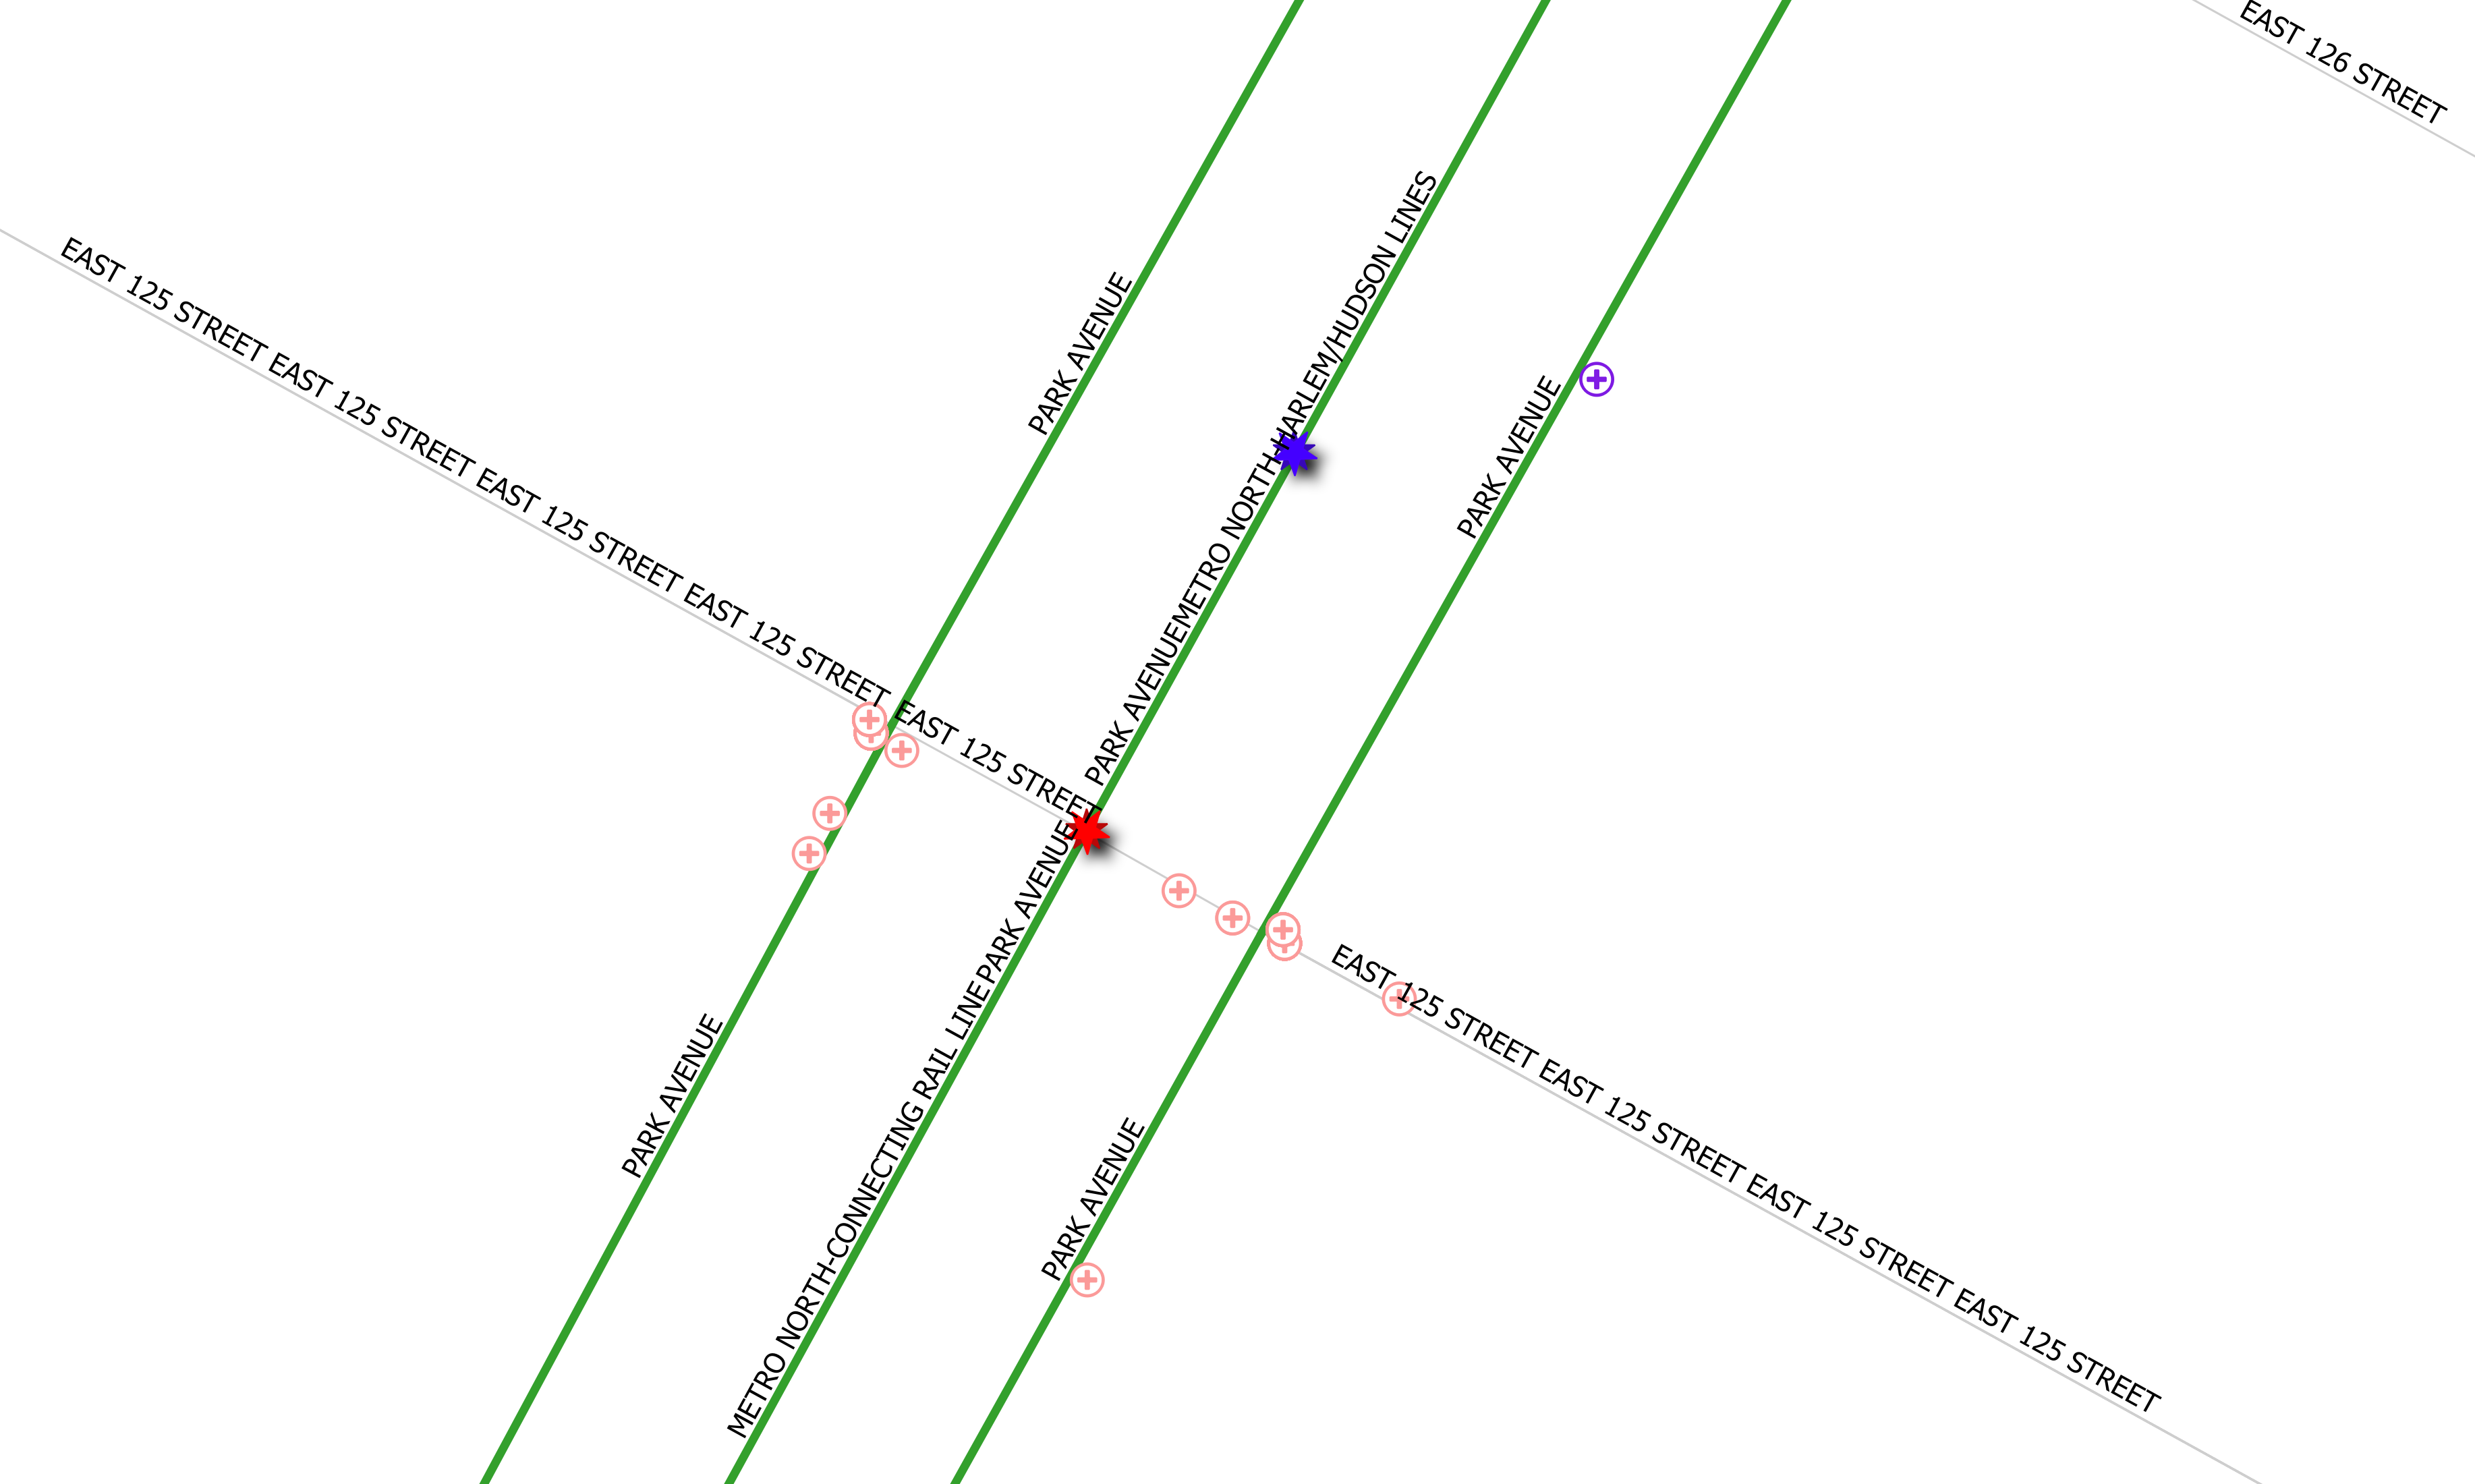

In [11]:
from IPython.display import Image
PATH = os.getcwd()
Image(filename = PATH + "Images\Fatalities_injuries_80919.png", width=1000, height=1000)

### Map of Corridor Crash Information for Study Area

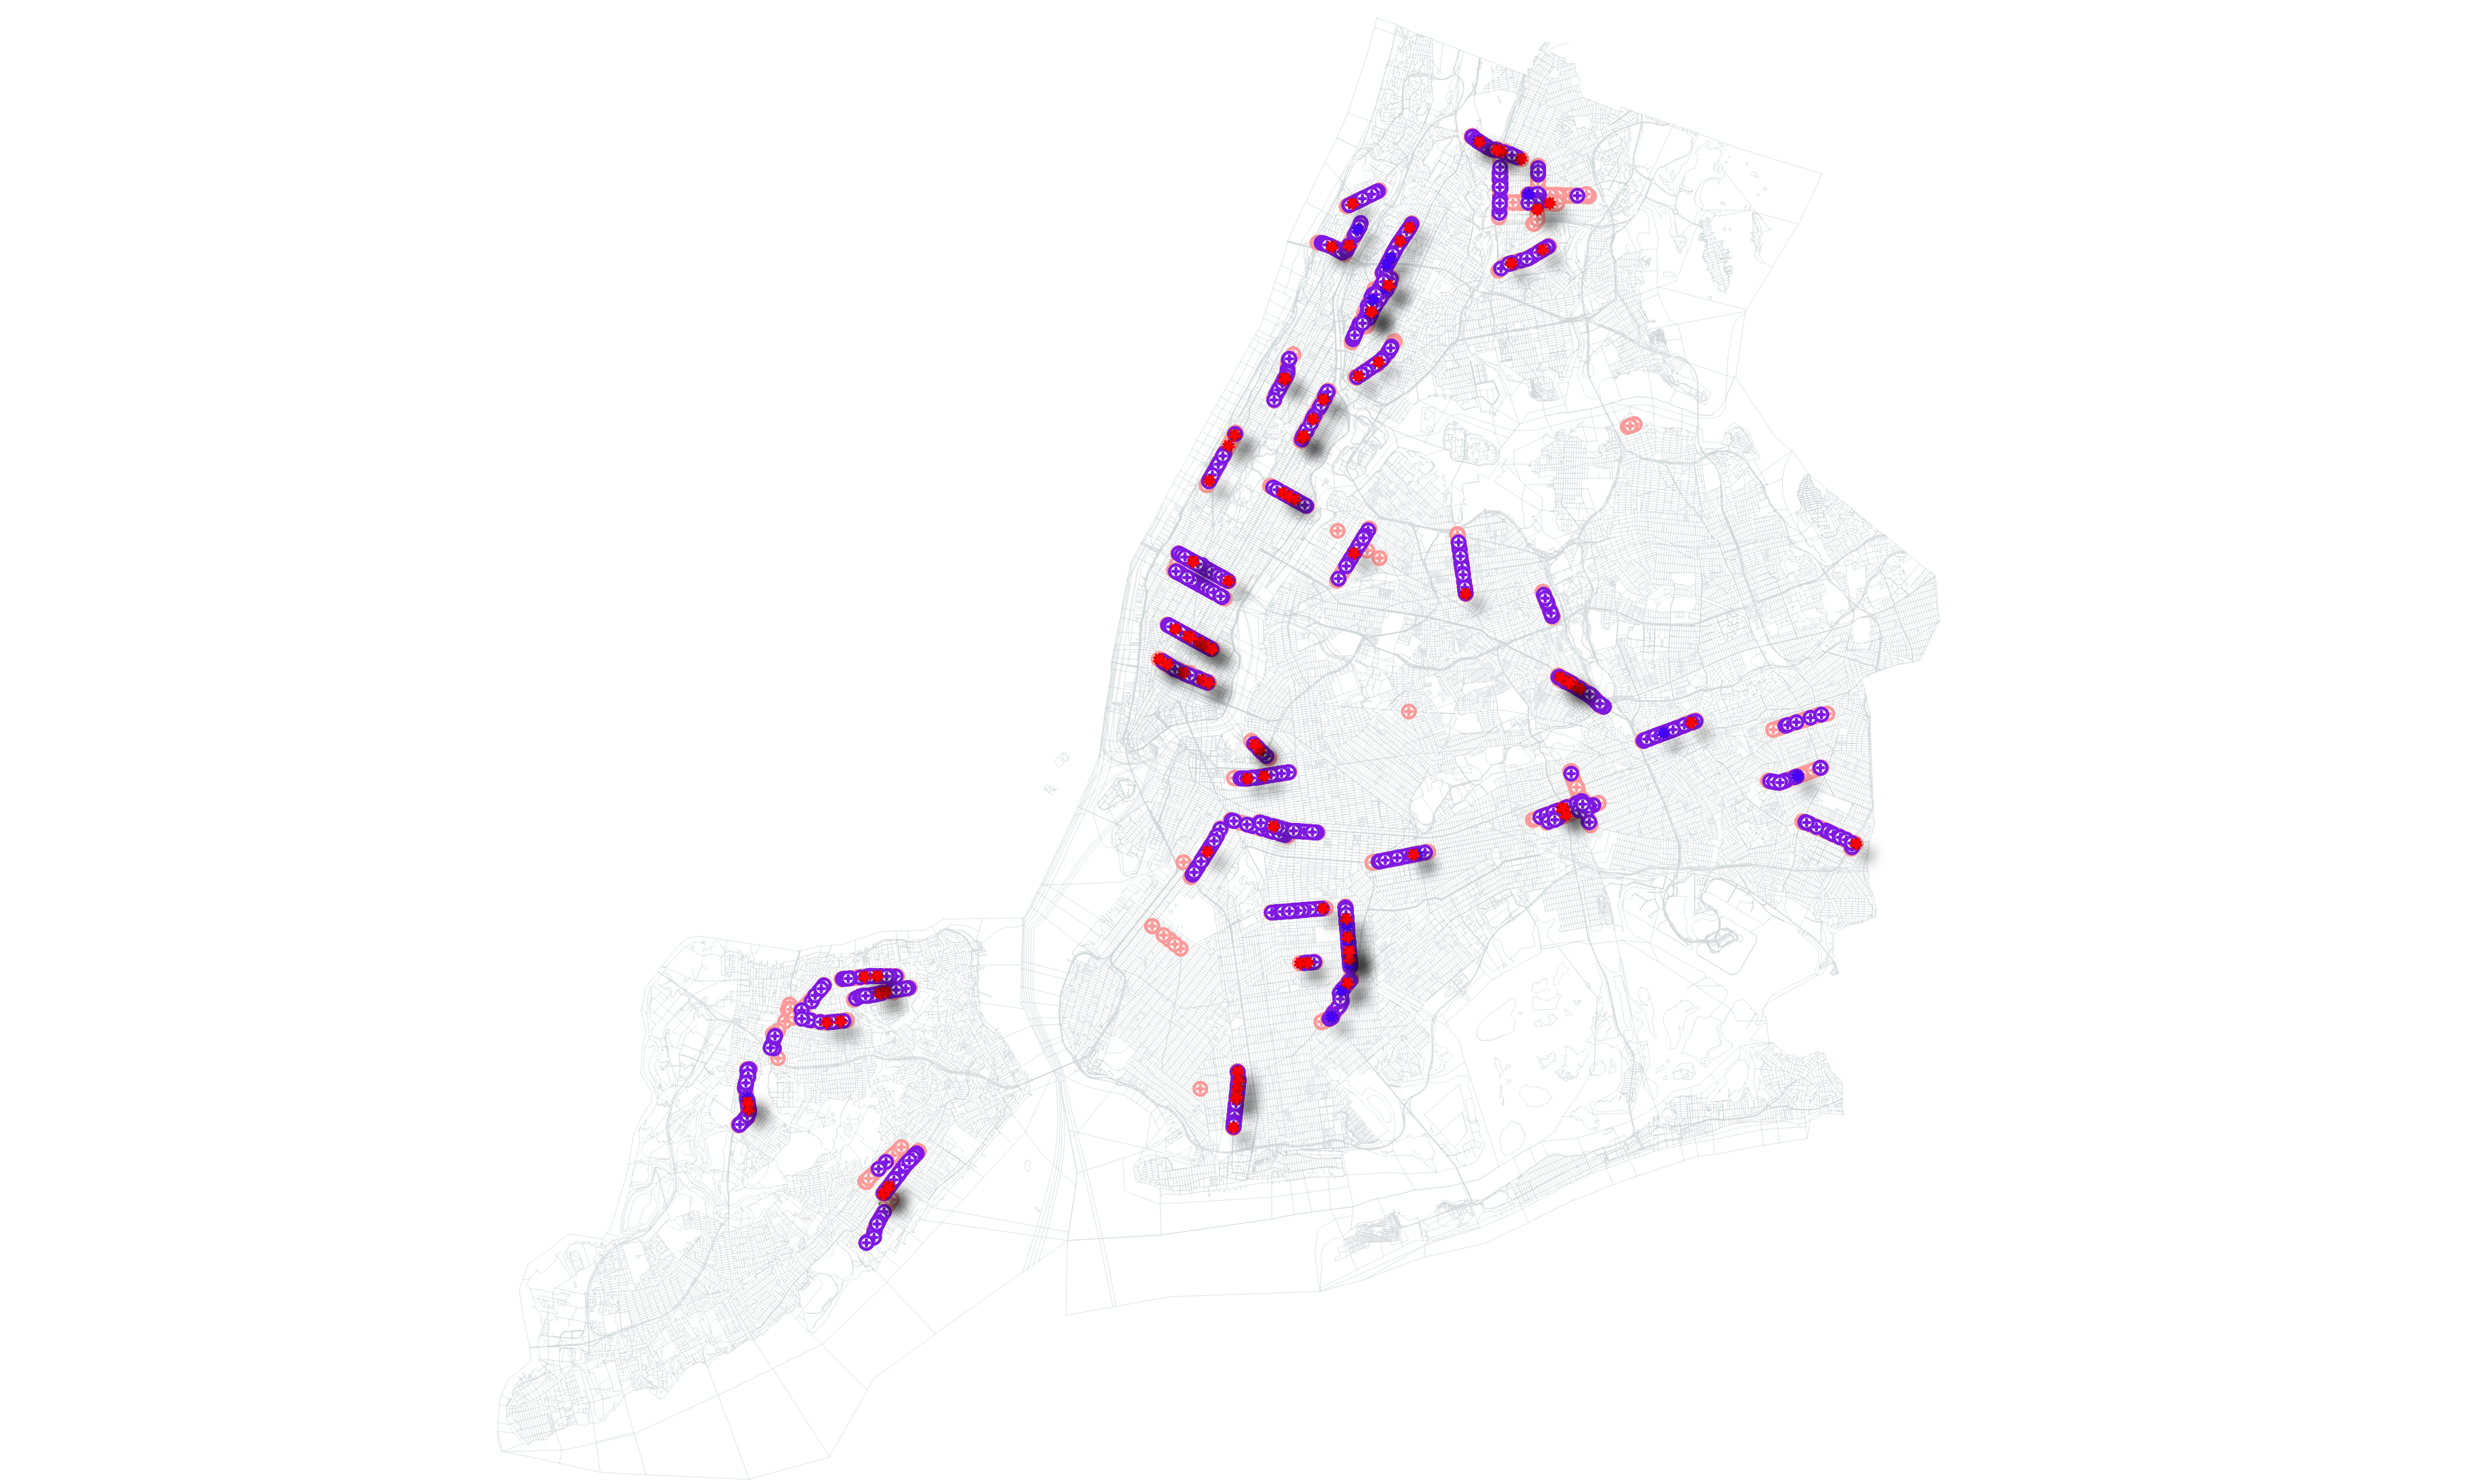

In [13]:
from IPython.display import Image
PATH = os.getcwd()
Image(filename = PATH + "Images\Fatalities_injuries_80919-full.png", width=1000, height=1000)

### Reading in headers for the excel table format

In [ ]:
df = pd.read_excel('Data\Corridors List_20190725.xlsx', sheet_name='Crash Database  ')
#df

cols=df.columns[8:18]

new_headers=map(str, cols)
#new_headers

new_headers.insert(0,str(df.columns[1]))

### CCD table headers

In [11]:
headers=map(str, ccd.columns)
#headers

### Renaming CCD headers to the headers for the formatted excel table

In [13]:
dictionary = [{i:j} for i,j in zip(headers, new_headers)]
for i in dictionary:        
    ccd=ccd.rename(columns=i)

#corridors_crash_data.columns
#corridors_crash_data

### Merging CCD Data with excel table

In [ ]:
# pd.merge(df.loc[:,df.columns[:8]],ccd, how='left').shape
data = df.loc[:, df.columns[:8]].merge(ccd, how='left')

### Exporting New table to CSV  

In [15]:
data.to_csv('Outputs\data-{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d')),index=False) 